In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
data = pd.read_csv('qcd_data.csv')
data['bkg_errsqr_hi'] = data['bkg_err_hi']**2
data['bkg_errsqr_lo'] = data['bkg_err_lo']**2

In [75]:
data.head()

,mr_lo,mr_hi,rsq_lo,rsq_hi,box,nb,region,counts_lo,bkg_lo,bkg_err_lo,counts_hi,bkg_hi,bkg_err_hi,transfer,transfer_err,bkg_errsqr_hi,bkg_errsqr_lo
0,400.0,600.0,0.20,0.22,dijet,0,lo,18407.0,11345.205078,100.625488,85649.0,5098.896973,87.987117,0.087670,0.002123,7741.732693,10125.488807
1,400.0,600.0,0.22,0.24,dijet,0,lo,13643.0,9203.333008,82.638542,52579.0,4039.025635,64.162041,0.091464,0.002982,4116.767560,6829.128636
2,400.0,600.0,0.24,0.26,dijet,0,lo,10762.0,7616.041504,72.081589,33069.0,2951.116455,57.330199,0.104455,0.004246,3286.751715,5195.755480
3,400.0,600.0,0.26,0.28,dijet,0,lo,8681.0,6489.835449,63.551295,21717.0,2429.794678,39.879180,0.113607,0.005916,1590.348961,4038.767121
4,400.0,600.0,0.28,0.30,dijet,0,lo,7116.0,5520.388672,56.306988,14262.0,1913.875732,34.772693,0.129219,0.008316,1209.140210,3170.476858


In [11]:
boxes = data['box'].unique()
btags = sorted(data['nb'].unique())
regions = data['region'].unique()

In [165]:
def get_transfer_factors(df_grouped):
    low = df_grouped['counts_lo'].sum()
    high = df_grouped['counts_hi'].sum()
    mc_low = df_grouped['bkg_lo'].sum()
    mc_high = df_grouped['bkg_hi'].sum()
    err_low = np.sqrt(low)
    err_high = np.sqrt(high)
    err_mc_low = np.sqrt(df_grouped['bkg_errsqr_lo'].sum())
    err_mc_high = np.sqrt(df_grouped['bkg_errsqr_hi'].sum())
        
    numer = low - mc_low
    denom = high - mc_high
    err_numer = np.sqrt(low + err_mc_low**2)
    err_denom = np.sqrt(high + err_mc_high**2)
    combined_sfs = (low - mc_low) / (high - mc_high)
    combined_sf_errs = np.sqrt( (err_numer/denom)**2 
                            + (numer*err_denom/(denom*denom))**2 )
    return combined_sfs, combined_sf_errs

In [166]:
# Compute combined scale factor using all b-tag bins
data['transfer_incl'] = np.nan
data['transfer_incl_err'] = np.nan
data['transfer_excl'] = np.nan
data['transfer_excl_err'] = np.nan
for box in boxes:
    for region in regions:
        d = data[(data['region'] == region) & (data['box'] == box)]
        grouped = d.groupby(['mr_lo', 'rsq_lo'])
        
        combined_sfs, combined_sf_errs = get_transfer_factors(grouped)
        for nb in btags:
            data.loc[(data['region'] == region) & (data['box'] == box) & (data['nb'] == nb), 
                'transfer_incl'] = combined_sfs.values
            data.loc[(data['region'] == region) & (data['box'] == box) & (data['nb'] == nb),
                'transfer_incl_err'] = combined_sf_errs.values
            
            grouped_excl = d[d['nb'] != nb].groupby(['mr_lo', 'rsq_lo'])
            combined_sfs_excl, combined_sf_errs_excl = get_transfer_factors(grouped_excl)
            data.loc[(data['region'] == region) & (data['box'] == box) & (data['nb'] == nb), 
                'transfer_excl'] = combined_sfs_excl.values
            data.loc[(data['region'] == region) & (data['box'] == box) & (data['nb'] == nb),
                'transfer_excl_err'] = combined_sf_errs_excl.values

In [114]:
def make_bar(box, region, max_y=0.30):
    fig, ax = plt.subplots(figsize=(20,8))
    width = 0.2
    colors = ['r','g','b']
    d = data[(data['region'] == region) & (data['box'] == box) & (data['nb'] == 0)]
    tfs = d['transfer_incl']
    errs = d['transfer_incl_err']
    x = np.arange(len(tfs))
    ax.bar(x, tfs, width, color='k', yerr=errs, label='Inclusive')
    for nb in btags:
        d = data[(data['nb'] == nb) 
                 & (data['region'] == region) & (data['box'] == box)]
        tfs = d['transfer']
        errs = d['transfer_err']
        labels = d['mr_lo'].astype(str) + ', ' + d['rsq_lo'].astype(str)
        x = np.arange(len(d)) + width * (nb+1)
        bars = ax.bar(x, tfs, width, color=colors[nb], yerr=errs, label=str(nb))
    ax.set_ylabel('Transfer factor')
    ax.set_title('QCD transfer factors for {} box, {} region'.format(box, region))
    plt.xticks(rotation=90)
    ax.set_xticks(np.arange(len(d))+0.5)
    ax.set_xticklabels(labels)
    ax.set_ylim([-0.05, max_y])
    ax.legend()
    plt.show()

### Compare inclusive QCD transfer factors to those derived in each b-tag bin

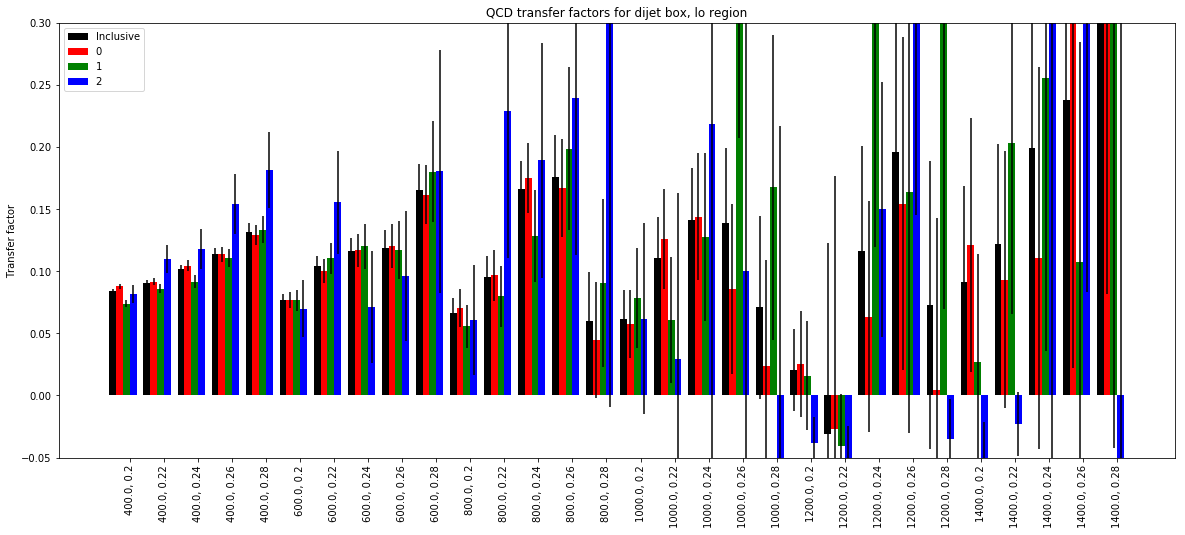

In [167]:
make_bar('dijet', 'lo', max_y=0.30)

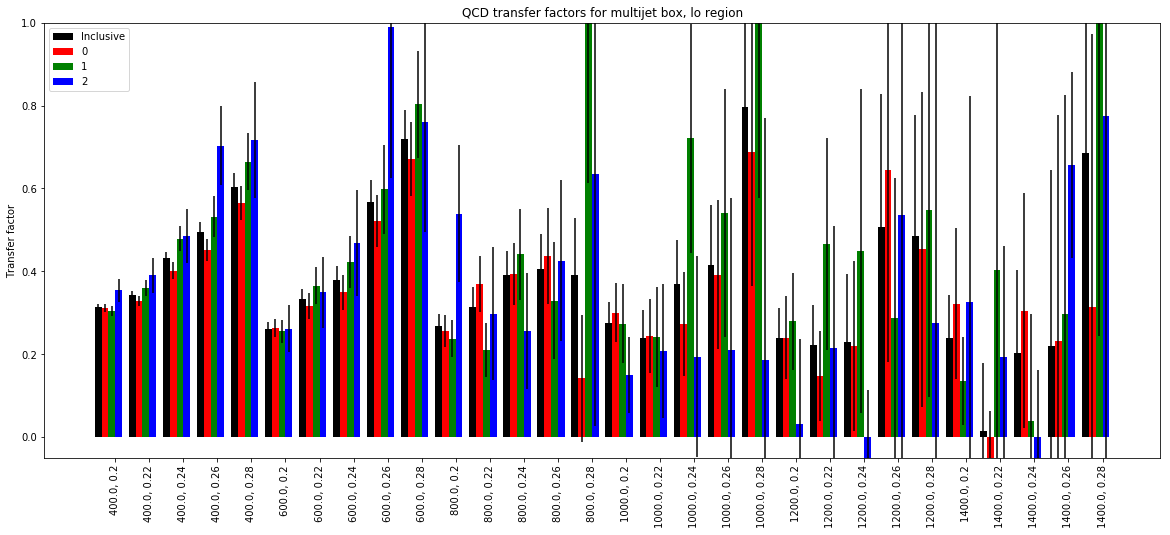

In [168]:
make_bar('multijet', 'lo', max_y=1.0)

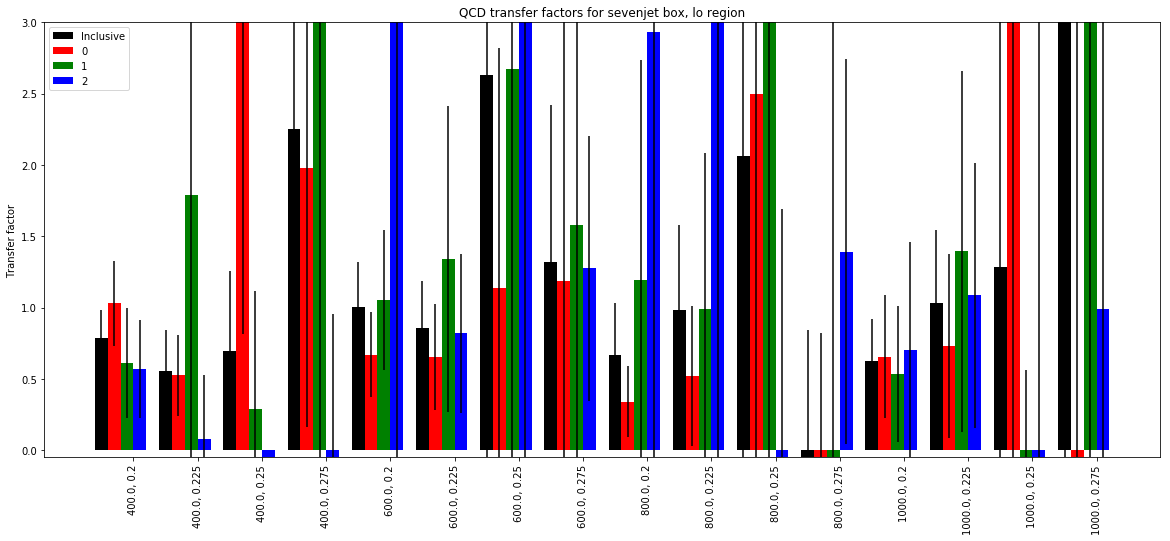

In [169]:
make_bar('sevenjet', 'lo', max_y=3.0)

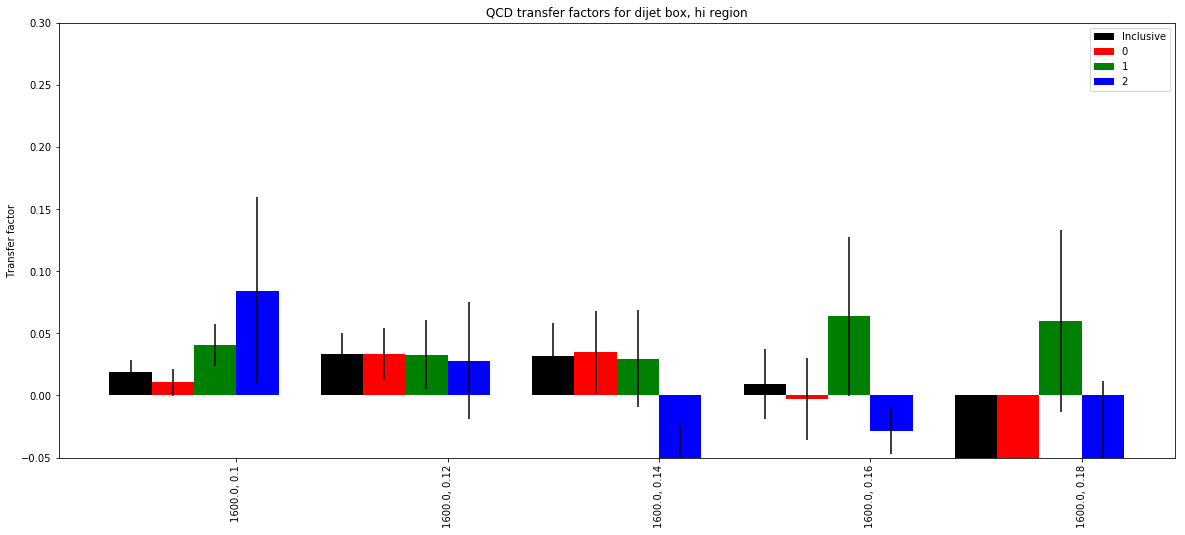

In [170]:
make_bar('dijet', 'hi', max_y=0.30)

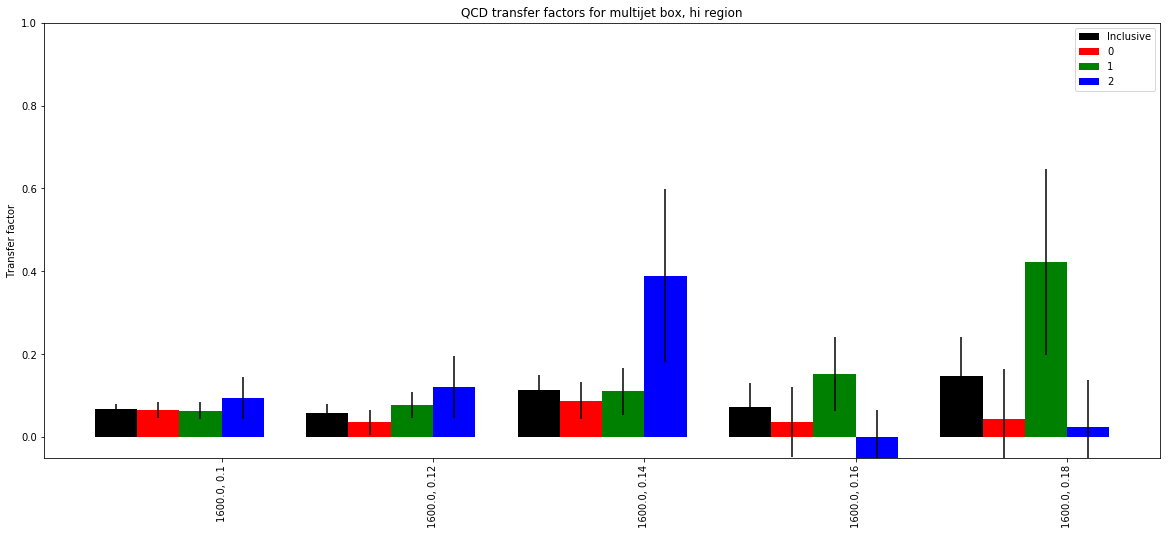

In [171]:
make_bar('multijet', 'hi', max_y=1.0)

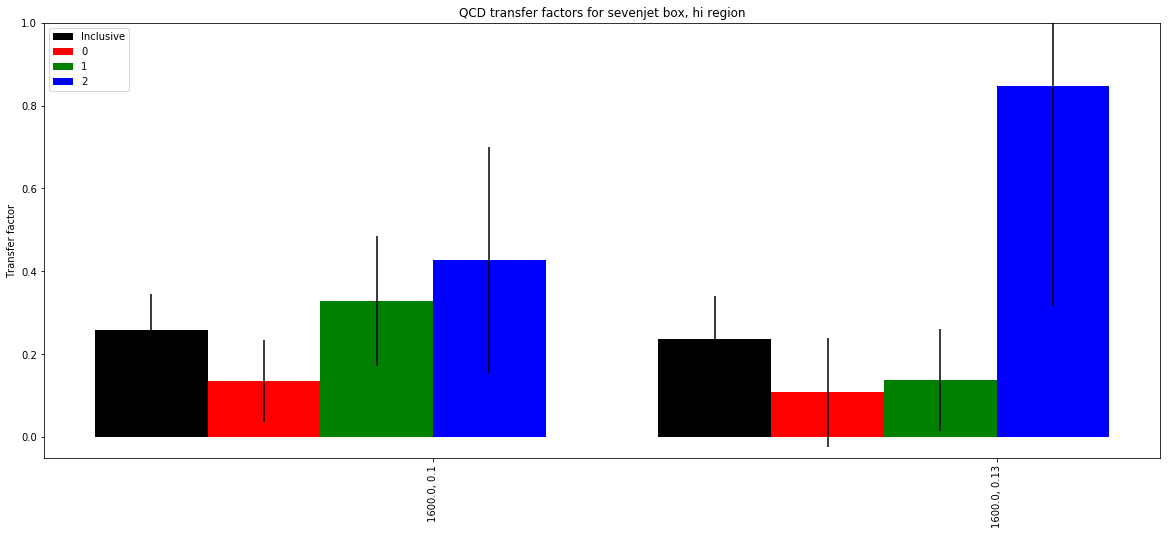

In [172]:
make_bar('sevenjet', 'hi', max_y=1.0)

Conclusion: the transfer factors in each b-tag bin are very similar and the inclusive transfer factors can be used instead of the separate b-tag ones.

### Quantify the difference between the inclusive and separate b-tag transfer factors

In [173]:
data['tf_diff'] = data['transfer'] - data['transfer_incl']
data['tf_diff_err'] = np.sqrt(data['transfer_err']**2 + data['transfer_incl_err']**2)
data['tf_diff_signif'] = data['tf_diff']/data['tf_diff_err']

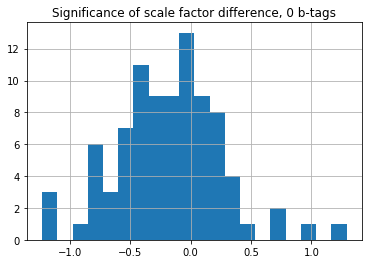

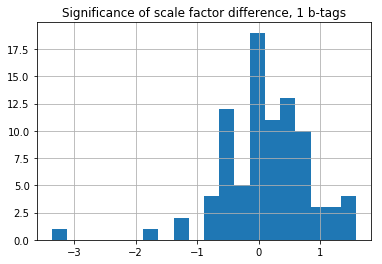

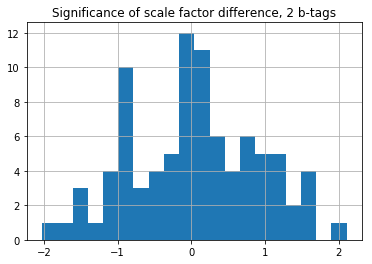

In [174]:
for nb in btags:
    data[data['nb'] == nb]['tf_diff_signif'].hist(bins=20)
    plt.title('Significance of scale factor difference, {} b-tags'.format(nb))
    plt.show()

The separate b-tag transfer factors look normally distributed around the inclusive transfer factors.  If there is a small bias we could use that to quantify the uncertainty on the assumption of non-dependence on b-tags.

In [175]:
for nb in btags:
    hist, bins = np.histogram(data[data['nb'] == nb]['tf_diff_signif'], bins=20, density=True)
    bins = 0.5 * (bins[:-1] + bins[1:])
    width = bins[1] - bins[0]
    mean = width * np.dot(hist, bins)
    std = np.sqrt(width * np.dot(hist, bins**2))
    print "{} b-tag bias: {}, std {}".format(nb, mean, std)

0 b-tag bias: -0.177428634079, std 0.469563467113
1 b-tag bias: 0.110462675026, std 0.731453650743
2 b-tag bias: 0.0401329894578, std 0.864251035312


The underdispersion could be due to using the same events twice when computing the separate and inclusive transfer factors.  Compare transfer factor values computed using Nb == 0 and Nb != 0, and similarly for 1 and 2 b-tags.

In [176]:
data['tf_diff_excl'] = data['transfer'] - data['transfer_excl']
data['tf_diff_err_excl'] = np.sqrt(data['transfer_err']**2 + data['transfer_excl_err']**2)
data['tf_diff_signif_excl'] = data['tf_diff_excl']/data['tf_diff_err_excl']

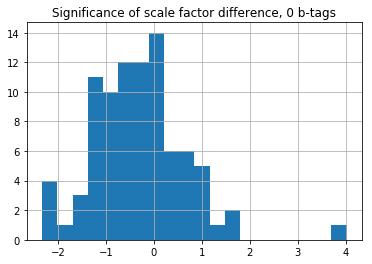

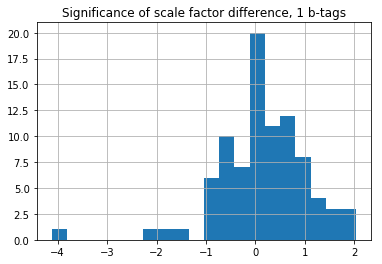

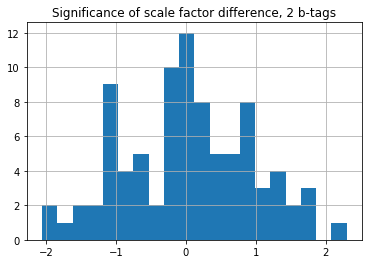

In [178]:
for nb in btags:
    data[data['nb'] == nb]['tf_diff_signif_excl'].hist(bins=20)
    plt.title('Significance of scale factor difference, {} b-tags'.format(nb))
    plt.show()

In [177]:
for nb in btags:
    hist, bins = np.histogram(data[data['nb'] == nb]['tf_diff_signif_excl'], bins=20, density=True)
    bins = 0.5 * (bins[:-1] + bins[1:])
    width = bins[1] - bins[0]
    mean = width * np.dot(hist, bins)
    std = np.sqrt(width * np.dot(hist, bins**2))
    print "{} b-tag bias: {}, std {}".format(nb, mean, std)

0 b-tag bias: -0.312012703573, std 1.00911263876
1 b-tag bias: 0.148817512708, std 0.908644240443
2 b-tag bias: 0.0372928453242, std 0.915545691774


Removing the overlap between the event samples gets rid of the underdispersion.  There is now a 4-sigma outlier (there is just one; the outlier in the first two plots is the same bin -- the lowest MR-Rsq bin in the dijet box) but otherwise it looks well behaved.  

There is a bias of 0.3 sigma when using the 1- and 2-btag transfer factors to describe the 0-btag category.  We can inflate the transfer factor uncertainties by 30% to cover this bias.